# Preprocessing
**Preprocessing** turns our raw data that is  for us and for the model hard to work with into data that we can use to effectively train machine learning algorithms.<br>

We can devide **Preprocessing** into **Data Engineering** and **Feature Engineering**

#### Data Engineering
Is the process of cleaning the raw data up to the point where we can do feature engineering.<br>
This can include:
- merging datasets
- formating data
- dealing with invalid measurements
- dropping irrelevant features


#### Feature Engineering
Is the process of using domain knowledge to transform data and create new features that optimize machine learning algorithms.
<br>
<br>

Note that there is not a hard line between **Data Engineering** and **Feature Engineering**. For example we can consider the replacement of missing values as being part of both. A data engineer might replace the missing values with zeroes to bring the raw data into proper form and then when it comes to feature engineering it might happen that replacing the missing values not with zeroes but with the mean turns out to improve the model performance.
<br>
<br>

# The Plan
**In this notebook** we will preprocess a toy dataset and in doing so show various preprocessing techniques and their effect on model performance.
<br> 
Our goal will be to predict the rating of restaurants using the [zomato datset](https://www.kaggle.com/datasets/rajeshrampure/zomato-dataset).<br>

## Table of Contents

* [Imports & Settings](#Imports_Settings)
* [Loading the Dataset](#loading_the_dataset)
* [Model and Model Evaluation](#model_and_model_evaluation)
* [Data Engineering](#data_engineering)
    * [Feature Selection](#feature_selection)
        * [1. Obviously Irrelevant Features](#obv_irr_features)
        * [2. Percent Missing Valuess](#per_miss_values)
        * [3. Amount of Variation](#amount_of_variation)
        * [4. Pairwise Correlation - Dropping Redundant Features](#pair_corr)
        * [5. Other Methods](#other_methods)
* [Feature Engineering](#feature_engineering)
     * [Missing Values](#missing_values)
     * [Encoding Nominal Variables](#encoding_nominal_variables)
     * [Feature Scaling](#feature_scaling)
     * [Missing Values Part 2](#missing_values_part_2)
         * [Artificial Neural Networks Imputation](#ann_imputation)
         * [KNN Imputation](#knn_imputation)

## Imports & Settings
<a id='Imports_Settings'></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown as md
import warnings

sns.color_palette("husl", 8);
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Loading the Dataset
<a id='loading_the_dataset'></a>

In [2]:
df = pd.read_csv("data/zomato_v2.csv")
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),cost in €
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,8.888889
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,8.888889
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,8.888889
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,3.333333
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,6.666667


## Model and Model Evaluation
We write a model function that takes the dataset and trains and validates a neural network using cross-validation.
<br>
https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn
<a id='model_and_model_evaluation'></a>

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate

def model_train_val(df, target="rate"):
    '''returns the average test score across 5 cross validation splits'''

    X = df.drop(columns=target)
    y = df[target]
        
    mlp = MLPRegressor(hidden_layer_sizes=(32,8,4), activation='relu', solver='adam', learning_rate_init=0.01)
   
    results = cross_validate(mlp, X, y, cv=5, return_train_score=True)
    
    return np.mean(results["test_score"])

# Data Engineering
<a id='data_engineering'></a>

## Feature selection
First of all, why do we even bother selecting features. Doing this does not give the model more data or extra information.<br>
And after all a good model would just select the important features and learn from them.<br>
So assuming we have a perfect/ideal model and enough samples there would be no reason to perform feature selection.<br>
Reading the previous sentence you are probably already thinking "can we really assume that our model is perfect?" and "when do we ever have enough samples?<br>
And so given the obvious answer to these questions we can thinking of feature selection as making the *job* of our model and thus aknowledging that its not perfect and it will not get "enough" samples.<br>

Now how does selecting features make the *job* of the model easier?<br>
By removing features that are redundant or irrelveant the model does not have to first learn to not use the features and can thus converge faster and possible also to a better optimum because the model does not have to bother with what is essentially just noise. This also speeds up the training time and less ressources are used in terms of computing power and memory.<br>
By removing the redundant/irrelevant feautes we also counteract the curse of dimensionality.<br>

Another advantage of feature selection is that the model becomes easier to interpret and the results easier to visualize.

<a id='feature_selection'></a>

### How to select Features

1. Obviously Irrelevant
2. Percent Missing Values
3. Amount of Variation
4. Pairwise Correlation
5. Other Methods

**What features could be relevant for predicting the rating of a restaurant?**

In [4]:
df.columns.to_list()

['url',
 'address',
 'name',
 'online_order',
 'book_table',
 'rate',
 'votes',
 'phone',
 'location',
 'rest_type',
 'dish_liked',
 'cuisines',
 'approx_cost(for two people)',
 'reviews_list',
 'menu_item',
 'listed_in(type)',
 'listed_in(city)',
 'cost in €']

### 1. Obviously Irrelevant Features
**url**, **address**, **name** and **phone** are unique for every restaurant and thus not a good indicator for restaurant rating<br>
<a id='obv_irr_features'></a>

In [5]:
df_selected = df.drop(columns=["url", "address", "name", "phone"])
df_selected.head()

,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),cost in €
0,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,8.888889
1,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,8.888889
2,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,8.888889
3,No,No,3.7/5,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,3.333333
4,No,No,3.8/5,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,6.666667


### 2. Percent Missing Values

If a feature contains to many missing values we can drop that feature ... or ... turn the the missingness into a feature itself.<br>
We will handle this in the `Missing Values` section.
<a id='per_miss_values'></a>

### 3. Amount of Variation

If a feature varies very little we can argue that it contains very little information and can thus be dropped.
<a id='amount_of_variation'></a>

In [6]:
df_selected.var()

/var/folders/65/kg2bqjyn62n9nyh0_0s86vmc0000gn/T/ipykernel_27882/4090858557.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_selected.var()


votes                          646156.901605
approx_cost(for two people)    192589.961498
cost in €                          23.776538
dtype: float64

In our case we don't have that many numeric features and the ones we have do not have a low varience, so we are not dropping any featueres here.

### 4. Pairwise Correlation - Dropping Redundant Features
If two features are highly correlated we can drop one of them
<a id='pair_corr'></a>

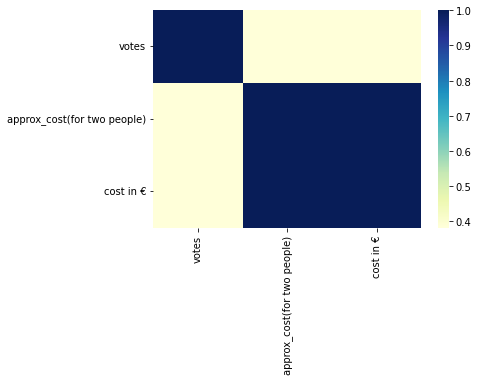

In [7]:
# we turn every features that allows for it into a numeric feature
# if this fails for a feature we "ignore" the error
df_tmp = df_selected.apply(pd.to_numeric, errors="ignore")

# we plot the correlation matrix with seaborn
sns.heatmap(df_tmp.corr(), cmap="YlGnBu");

As we can see `approx_cost(for two people)` and `cost in €` correlate 1 to 1,<br>
so we are not gaining any information by keeping them both

In [8]:
df_selected_2 = df_selected.drop(columns=["approx_cost(for two people)"])

<br>


Another pair of features that is very highly correlated is `location` and `listed_in(city)` (city of restaurant).<br>
We can view `location` as a more specific version of `listed_in(city)`. <br>
Because there are too many unique values in `location`, which would increase our input dimensionality too much,<br>
we dicide to drop it and keep just the `listed_in(city)`.

In [9]:
df_selected_3 = df_selected_2.drop(columns=["location"])

We can assume the same kind of correlation between `rest_type` and `listed_in(type)`.<br>
If the correlation of alphabetical features is not obvious we could also use some nlp, for example [N-grams](https://www.tidytextmining.com/ngrams.html).<br>
We dicide to drop `listed_in(type)` because it contains less restaurant types.

In [10]:
df_selected_4 = df_selected_3.drop(columns=["listed_in(type)"])

### 5. Other Methods
Feature selection is a huge topic and I will link to some further ressources.
As a piece of general advice, feature selection is considered NP-hard and it can happen that the time it takes to select features is not in proportion to the time saved during training. So it can pay off to do simply things and always make sure what you are doing works. It also makes sense to stick with established code, for example from scikit-learn.<br>
Here are some further ressources:<br>
[Sklearn Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
<a id='other_methods'></a>

#### more dropping
For our last step we will drop features that hold valuable information but are for now to complex to process.<br>
These features are the **list of reviews** and the **menu**


In [11]:
df_selected_5 = df_selected_4.drop(columns=["reviews_list", "menu_item"])

<br>

# Feature Engineering 
<a id='feature_engineering'></a>

## Missing Values
To handle missing values we have several options
- dropping
- imputation
- turn them into a feature

For the imputation option we have various methods that we can use.<br>
*But which method is the best?*<br>
A [review](https://www.sciencedirect.com/science/article/pii/S2352914821002653) that covered 197 atricles that applied different imputation methods from 2010-2021 came to the conclusion,<br>
that there is no single best method that always works.<br>
Instead the performance of a imputation methods depend on multiple factors, such as:
- feature selection
- outlier detection 
- feature normalization
- classifier(s)
- field of application

So what we will do here, is apply, *when necessary*, 2 commonly used methods which are<br>
**"k-Nearest Neighbour imputation"** and **"Artifical Neural Network imputation"**<br>
and then see what works best.
<a id='missing_values'></a>

In [12]:
# we can check in which columns there are missing values and how many
df_selected_5.isnull().sum()

online_order           0
book_table             0
rate                7775
votes                  0
rest_type            227
dish_liked         28078
cuisines              45
listed_in(city)        0
cost in €            346
dtype: int64

Starting with the **rate** column we can see that some restaurants do not have a rating.<br>
Because the ratings are the targets we are trying to predict it makes sense to drop the rows where the rating is missing.
Ratings are missing if the values is either `nan`, `NEW` or `-`

In [13]:
df_selected_5["rate"].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [14]:
to_drop = [np.nan, "NEW", "-"]
df_dropped = df_selected_5[~df_selected_5['rate'].isin(to_drop)]

In [15]:
df_dropped["rate"].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5', '4.5/5',
       '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5', '3.4 /5',
       '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5', '4.1 /5',
       '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5', '3.5 /5',
       '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5', '4.3 /5',
       '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5', '4.9 /5',
       '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5', '2.1 /5',
       '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

<br>

So then the next column to take care of is **rest_type**, which describes the type of restaurant

In [16]:
df_dropped.loc[995:1000, "rest_type"]

995     Casual Dining
996     Casual Dining
997     Casual Dining
998       Quick Bites
999               NaN
1000    Casual Dining
Name: rest_type, dtype: object

Here we can fill the NaNs with "undefined" which we can later encode as its own category.<br>
So we will e.g. have the categories `["Casual Dining", "Quick Bites", "undefined"]`

In [18]:
# with this syntax we could also replace the NaNs in multiple columns with different values
# {"some_column": "some_value", "other_column": "other_value"}
df_dropped.fillna({"rest_type": "undefined"}, inplace=True)

In [19]:
df_dropped.loc[995:1000, "rest_type"]

995     Casual Dining
996     Casual Dining
997     Casual Dining
998       Quick Bites
999         undefined
1000    Casual Dining
Name: rest_type, dtype: object

<br>
<br>

Next up is **dish_liked**, which contains dished that most people liked

In [20]:
df_dropped["dish_liked"].tail()

51709                             NaN
51711            Biryani, Andhra Meal
51712                             NaN
51715    Cocktails, Pizza, Buttermilk
51716                             NaN
Name: dish_liked, dtype: object

Eventually we will have to turn the liked dishes into a numerical feature.<br>
To keep things feasable we could extract maybe the 10 most common meals and then one-hot encode these and drop the rest. Not the whole row but just from the `dish_liked` column<br>
This however would also leave a lot of restaurants with out any liked dishes even if they had them before, which could end up confusing ther model 

What is interesting for this feature is that ~46% of the restaurants it is missing, which is almost half.

In [21]:
df_dropped["dish_liked"].isnull().mean()

0.43688947557902313

This discovery gives us another option of what to do with this column. Which is turning *whether or not there are liked dishes* into a feature itself.<br>
From this the model might learn something like: "No liked dishes correlate with lower rating".<br>
We will store this feature in the column `has_liked_dishes` and drop the `dish_liked` column.

In [22]:
df_dropped["has_liked_dishes"] = df_dropped["dish_liked"].notnull()

In [23]:
df_dropped["has_liked_dishes"].tail()

51709    False
51711     True
51712    False
51715     True
51716    False
Name: has_liked_dishes, dtype: bool

In [24]:
df_dropped.drop(columns=["dish_liked"], inplace=True)

<br>
<br>

**cuisines**

In [25]:
df_dropped.loc[435:440, "cuisines"]

435                        North Indian
437    Healthy Food, North Indian, Thai
440                                 NaN
Name: cuisines, dtype: object

In [26]:
df_dropped["cuisines"].isnull().sum()

11

For this feature there are only 11 missing values. For us that means it's not worth considering and we can just drop the respective rows.

In [27]:
df_dropped_2 = df_dropped.loc[df_dropped["cuisines"].notna(), :]

<br>
<br>

**cost in €**
For this feature we will finally apply the imputation methods that we mentioned in the beginning.<br>
**"k-Nearest Neighbours imputation"** and **"Artifical Neural Network imputation"**<br>

In [28]:
df_dropped_2["cost in €"].unique()

array([ 8.88888889,  3.33333333,  6.66666667,  7.77777778,  6.11111111,
        5.55555556,  5.        ,  7.22222222,  4.44444444, 10.        ,
        2.22222222,  8.33333333,  1.66666667,  9.44444444,  1.11111111,
       13.33333333,  3.88888889,  2.77777778, 10.55555556, 11.11111111,
       16.66666667, 14.44444444,  2.21111111, 12.22222222, 17.77777778,
        2.55555556,  1.44444444, 18.88888889, 15.        , 24.44444444,
       15.55555556, 22.22222222, 20.        ,         nan, 21.11111111,
        2.        ,  3.66666667, 27.77777778, 23.33333333, 33.33333333,
       31.11111111, 37.77777778,  0.55555556,  0.44444444, 13.88888889,
       38.88888889, 44.44444444, 26.66666667, 28.88888889, 16.11111111,
        0.77777778, 35.55555556,  2.66666667, 66.66666667, 11.66666667,
       25.55555556, 45.55555556,  1.33333333, 55.55555556, 41.11111111,
       18.33333333, 30.        , 50.        ,  0.88888889])

#### k-Nearest Neighbours imputation (but not yet actually)
**knn imputation** and also **ann imputation** require a fully numerical and also normalized dataset.<br>
So before we can apply either of them we have to jump to some other preprocessing steps.

In [29]:
df_dropped_2.head()

,online_order,book_table,rate,votes,rest_type,cuisines,listed_in(city),cost in €,has_liked_dishes
0,Yes,Yes,4.1/5,775,Casual Dining,"North Indian, Mughlai, Chinese",Banashankari,8.888889,True
1,Yes,No,4.1/5,787,Casual Dining,"Chinese, North Indian, Thai",Banashankari,8.888889,True
2,Yes,No,3.8/5,918,"Cafe, Casual Dining","Cafe, Mexican, Italian",Banashankari,8.888889,True
3,No,No,3.7/5,88,Quick Bites,"South Indian, North Indian",Banashankari,3.333333,True
4,No,No,3.8/5,166,Casual Dining,"North Indian, Rajasthani",Banashankari,6.666667,True


<br>

## Encoding Nominal Variables
In our dataset the **nominal variables**, so columns that contain names or strings, are:
<a id='encoding_nominal_variables'></a>

In [30]:
from pandas.api.types import is_numeric_dtype

[c for c in df_dropped_2 if not is_numeric_dtype(df_dropped_2[c])]

['online_order',
 'book_table',
 'rate',
 'rest_type',
 'cuisines',
 'listed_in(city)']

If we want to feed these **nominal variables** into our model, we have to turn them into **numerical variables**.
<br>
<br>
We can start with the columns `online_order` and `book_table`.

In [31]:
df_dropped_2.loc[:, ["online_order", "book_table"]].head()

,online_order,book_table
0,Yes,Yes
1,Yes,No
2,Yes,No
3,No,No
4,No,No


Both features have values that are either `Yes` or `No`.<br>
We can encode `Yes`and `No` as `True` and `False`

In [33]:
df_dropped_2["online_order"] = df_dropped_2["online_order"].map({"Yes": True, "No": False})
df_dropped_2["book_table"]   = df_dropped_2["book_table"].map({"Yes": True, "No": False})

In [34]:
df_dropped_2.loc[:, ["online_order", "book_table"]].head()

,online_order,book_table
0,True,True
1,True,False
2,True,False
3,False,False
4,False,False


<br>

Next we can take care of the column `rate`, which will be our target later.

In [35]:
df_dropped_2["rate"].head()

0    4.1/5
1    4.1/5
2    3.8/5
3    3.7/5
4    3.8/5
Name: rate, dtype: object

Here we are dealing with `strings` of fractions. To turn them into floats we can remove the `/5` part and then cast the remaining part to `float`.


In [36]:
df_dropped_2["rate"] = df_dropped_2["rate"].apply(lambda x: float(x.replace('/5', '')))

In [37]:
df_dropped_2["rate"].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

<br>
<br>

**rest_type**<br>
In the *restaurant type* column we have 88 different categories.

In [38]:
df_dropped_2["rest_type"].head()

0          Casual Dining
1          Casual Dining
2    Cafe, Casual Dining
3            Quick Bites
4          Casual Dining
Name: rest_type, dtype: object

A very simple approach would be to directly one-hot encode the whole column. This would add the following information to our dataframe.<br>

In [40]:
one_hot = pd.get_dummies(df_dropped_2['rest_type'])
one_hot

,Bakery,"Bakery, Beverage Shop","Bakery, Cafe","Bakery, Dessert Parlor","Bakery, Food Court","Bakery, Quick Bites",Bar,"Bar, Casual Dining","Bar, Lounge","Bar, Pub",...,"Quick Bites, Food Court","Quick Bites, Kiosk","Quick Bites, Meat Shop","Quick Bites, Mess","Quick Bites, Sweet Shop",Sweet Shop,"Sweet Shop, Quick Bites",Takeaway,"Takeaway, Delivery",undefined
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51712,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51715,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


But what we can see is that there are a lot of joined restaurant types that have their own column.<br>
We can reduce the dimensionality by splitting these joined restaurant types.<br>
So a restaurant that had a `1` in the column `Bar, Casual Dining` would then have a `1` in the column `Bar` and in the column `Casual Dining`

In [41]:
types = [rest_types.split(", ") for rest_types in df_dropped_2['rest_type'].unique()]

# flatten
types_unique = []
for t in types:
    types_unique.extend(t)

# remove duplicates
types_unique = set(types_unique)
types_unique

{'Bakery',
 'Bar',
 'Beverage Shop',
 'Bhojanalya',
 'Cafe',
 'Casual Dining',
 'Club',
 'Confectionery',
 'Delivery',
 'Dessert Parlor',
 'Dhaba',
 'Fine Dining',
 'Food Court',
 'Food Truck',
 'Irani Cafee',
 'Kiosk',
 'Lounge',
 'Meat Shop',
 'Mess',
 'Microbrewery',
 'Pub',
 'Quick Bites',
 'Sweet Shop',
 'Takeaway',
 'undefined'}

And with that we reduced the number of categories to **25** :D<br>
Now we have to match these categories with the `rest_type` column.

In [42]:
for t in types_unique:
    df_dropped_2[t] = df_dropped_2['rest_type'].str.contains(t)

In [53]:
df_dropped_2.head()

,online_order,book_table,rate,votes,rest_type,cuisines,listed_in(city),cost in €,has_liked_dishes,Mess,...,Fine Dining,Sweet Shop,Casual Dining,Delivery,Kiosk,Irani Cafee,Club,Quick Bites,Lounge,Bakery
0,True,True,4.1,775,Casual Dining,"North Indian, Mughlai, Chinese",Banashankari,8.888889,True,False,...,False,False,True,False,False,False,False,False,False,False
1,True,False,4.1,787,Casual Dining,"Chinese, North Indian, Thai",Banashankari,8.888889,True,False,...,False,False,True,False,False,False,False,False,False,False
2,True,False,3.8,918,"Cafe, Casual Dining","Cafe, Mexican, Italian",Banashankari,8.888889,True,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,3.7,88,Quick Bites,"South Indian, North Indian",Banashankari,3.333333,True,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,3.8,166,Casual Dining,"North Indian, Rajasthani",Banashankari,6.666667,True,False,...,False,False,True,False,False,False,False,False,False,False


With that we can drop the `rest_type` column.

In [54]:
df_dropped_3 = df_dropped_2.drop(columns=["rest_type"])

<br>
<br>

**cuisines**<br>
In this column we have 2383 different categories. Thats quite a lot.

In [55]:
df_dropped_3.loc[30:35, "cuisines"]

30                               Cafe, Italian
31    North Indian, Fast Food, Chinese, Burger
32                            Bakery, Desserts
33                                       Pizza
34            North Indian, Biryani, Fast Food
35                                     Biryani
Name: cuisines, dtype: object

But looking at the first few rows, we notice that we can apply the same technique that we applied to the restaurant types.<br>
We also notice that there is some overlap between restaurant type and cuisines. For example with `Bakery`and `Cafe`.
To resolve this issue we add will add a `_c`for the column names, such that the restaurant type columns are not overwritten.

In [56]:
cuisines = [c.split(", ") for c in df_dropped_3['cuisines'].unique()]


# flatten
cuisines_unique = []
for c in cuisines:
    cuisines_unique.extend(c)

# remove duplicates
cuisines_unique = set(cuisines_unique)

With that we reduced the number of categories to **105** 

In [57]:
# creating the new columns
for c in cuisines_unique:
    df_dropped_3[f"{c}_c"] = df_dropped_3['cuisines'].str.contains(c)

In [58]:
df_dropped_3.head()

,online_order,book_table,rate,votes,cuisines,listed_in(city),cost in €,has_liked_dishes,Mess,Bhojanalya,...,Awadhi_c,Bubble Tea_c,Pizza_c,Coffee_c,Afghani_c,Japanese_c,Modern Indian_c,Mughlai_c,German_c,Australian_c
0,True,True,4.1,775,"North Indian, Mughlai, Chinese",Banashankari,8.888889,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,True,False,4.1,787,"Chinese, North Indian, Thai",Banashankari,8.888889,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,3.8,918,"Cafe, Mexican, Italian",Banashankari,8.888889,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,3.7,88,"South Indian, North Indian",Banashankari,3.333333,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,3.8,166,"North Indian, Rajasthani",Banashankari,6.666667,True,False,False,...,False,False,False,False,False,False,False,False,False,False


And we also drop the `cuisines` column

In [59]:
df_dropped_4 = df_dropped_3.drop(columns=["cuisines"])

<br>
<br>

**listed_in(city)**<br>
For this column we can apply a simple one-hot encoding.

In [60]:
df_dropped_4["listed_in(city)"].unique()

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

In [61]:
one_hot = pd.get_dummies(df_dropped_4['listed_in(city)'])
one_hot.head()

,BTM,Banashankari,Bannerghatta Road,Basavanagudi,Bellandur,Brigade Road,Brookefield,Church Street,Electronic City,Frazer Town,...,Lavelle Road,MG Road,Malleshwaram,Marathahalli,New BEL Road,Old Airport Road,Rajajinagar,Residency Road,Sarjapur Road,Whitefield
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This newly created dataframe we can concatenate with out original dataframe<br>
And again we drop the alphabetical column.

In [62]:
df_dropped_5 = df_dropped_4.drop(columns=["listed_in(city)"])

df = pd.concat([df_dropped_5, one_hot], axis=1)
df.head()

,online_order,book_table,rate,votes,cost in €,has_liked_dishes,Mess,Bhojanalya,Cafe,Pub,...,Lavelle Road,MG Road,Malleshwaram,Marathahalli,New BEL Road,Old Airport Road,Rajajinagar,Residency Road,Sarjapur Road,Whitefield
0,True,True,4.1,775,8.888889,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,True,False,4.1,787,8.888889,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,True,False,3.8,918,8.888889,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,False,False,3.7,88,3.333333,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,3.8,166,6.666667,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Now every feature in our dataframe is numeric.

In [63]:
all([is_numeric_dtype(df[c]) for c in df])

True

<br>

### evaluating the model
At this step we can already train and evaluate our model with the data.<br>
But not with the full dataset, because we still have missing values in the `cost in €` column.

In [64]:
def model_train_val(df, target="rate"):
    '''returns the average test score across 5 cross validation splits'''

    X = df.drop(columns=target)
    y = df[target]
        
    mlp = MLPRegressor(hidden_layer_sizes=(32,8,4), activation='relu', solver='adam', learning_rate_init=0.01)
   
    results = cross_validate(mlp, X, y, cv=5, return_train_score=True)
    
    return np.mean(results["test_score"])

In [65]:
df_subset = df.drop(columns=["cost in €"])
score_base = model_train_val(df_subset, target="rate")

Now we have a baseline that we can try to improve on.

In [66]:
score_base

0.3861303690060281

<br>

## Feature Scaling
Feature scaling is used to make sure that every feature is treated with equal importance.<br>
Imagine the unscaled features `age` and `height`.<br>
Age might have values between `0.0-100.0` while height might have values between `1.00-2.00`. Without any sclaing the model would think that age has a greate effect on the prediction than height.<br>

The feature scaling we will apply to our data is `standardization`, so that our features have zero mean and unit variance.
<a id='feature_scaling'></a>

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
# select numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# instantiate StandardScaler object
scaler = StandardScaler()

# fit scaler to numerical columns only
scaler.fit(df[num_cols])

# transform numerical columns only
df[num_cols] = scaler.transform(df[num_cols])

### evaluate the model

In [69]:
df_subset = df.drop(columns=["cost in €"])
score_features_scaled = model_train_val(df_subset, target="rate")

In [70]:
score_base

0.3861303690060281

In [71]:
score_features_scaled

0.5304133961110058

<br>

## Missing Values part 2
Now can finally finish the missing value imputation using **KNN imputation** and **Aritficial Neural Networks**.<br>
We left of at `cost in €` which is the only remaining feature containing missing values.
<a id='missing_values_part_2'></a>

In [72]:
df.isnull().sum()[df.isnull().sum() != 0]

cost in €    244
dtype: int64

### Artificial Neural Networks Imputation
<a id='ann_imputation'></a>

copy df so we can also have the original one for the knn imputation

In [73]:
df_ann = df.copy()

select the rows where `cost in €` is not missing

In [74]:
df_cost_not_missing = df_ann.loc[~df_ann.loc[:, "cost in €"].isnull()]

In [75]:
df_cost_not_missing

,online_order,book_table,rate,votes,cost in €,has_liked_dishes,Mess,Bhojanalya,Cafe,Pub,...,Lavelle Road,MG Road,Malleshwaram,Marathahalli,New BEL Road,Old Airport Road,Rajajinagar,Residency Road,Sarjapur Road,Whitefield
0,True,True,0.906841,0.479978,0.423577,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,True,False,0.906841,0.493585,0.423577,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,True,False,0.225852,0.642131,0.423577,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,False,False,-0.001144,-0.299037,-0.653198,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,0.225852,-0.210590,-0.007133,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51709,False,False,-0.001144,-0.360269,0.423577,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
51711,False,False,-2.725100,-0.306974,0.423577,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
51712,False,False,-0.228141,-0.368207,1.931062,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
51715,False,True,1.360833,-0.131214,4.084612,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1


train model

In [76]:
def ann_missing_value_imputation(df, target="cost in €"):
    # we also drop the rate column, otherwise our model could "cheat"
    X = df.drop(columns=target).drop(columns="rate")
    y = df[target]
        
    mlp = MLPRegressor(hidden_layer_sizes=(16,8,4), activation='relu', solver='adam')
   
    results = cross_validate(mlp, X, y, cv=5, return_train_score=True, return_estimator=True)
    return results

In [77]:
results = ann_missing_value_imputation(df_cost_not_missing)

/opt/homebrew/Caskroom/miniforge/base/envs/py/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [78]:
results

{'fit_time': array([23.83092618, 19.09277296, 17.53243542, 17.9879899 , 13.11910677]),
 'score_time': array([0.00477791, 0.00430417, 0.00594878, 0.00619721, 0.00528622]),
 'estimator': [MLPRegressor(hidden_layer_sizes=(16, 8, 4)),
  MLPRegressor(hidden_layer_sizes=(16, 8, 4)),
  MLPRegressor(hidden_layer_sizes=(16, 8, 4)),
  MLPRegressor(hidden_layer_sizes=(16, 8, 4)),
  MLPRegressor(hidden_layer_sizes=(16, 8, 4))],
 'test_score': array([0.85137401, 0.85261451, 0.77266581, 0.77244577, 0.80015952]),
 'train_score': array([0.92856298, 0.92732441, 0.93384961, 0.92043397, 0.92401619])}

Select a model.

In [79]:
model = results["estimator"][0]

predict the missing values

In [80]:
df_cost_missing = df_ann.loc[df_ann.loc[:, "cost in €"].isnull()]

X = df_cost_missing.drop(columns = "cost in €").drop(columns = "rate")

predicted_cost = model.predict(X)

In [86]:
df_cost_missing

,online_order,book_table,rate,votes,cost in €,has_liked_dishes,Mess,Bhojanalya,Cafe,Pub,...,Lavelle Road,MG Road,Malleshwaram,Marathahalli,New BEL Road,Old Airport Road,Rajajinagar,Residency Road,Sarjapur Road,Whitefield
3774,False,False,0.452848,-0.130080,1.332973,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3954,False,False,-1.136126,-0.384082,-0.390814,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4040,False,False,-0.909129,-0.392020,-0.316365,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4852,False,False,0.452848,-0.130080,1.332973,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4952,False,False,0.452848,-0.130080,1.332973,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50702,False,False,-1.136126,-0.394288,-0.037225,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
50940,False,False,0.679844,-0.308108,-0.468808,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
51247,False,False,-2.498103,-0.312644,0.250820,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
51271,False,False,-1.136126,-0.394288,-0.037225,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1


add the predicted values to the dataframe

In [84]:
df_cost_missing.loc[:, "cost in €"] = predicted_cost

combine with the original dataset

In [87]:
df_ann.loc[:, "cost in €"] = df_ann.loc[:, "cost in €"].combine_first(df_cost_missing.loc[:, "cost in €"])

### evaluate model

In [88]:
score_ann_impute = model_train_val(df_ann, target="rate")

In [89]:
score_base

0.3861303690060281

In [90]:
score_features_scaled

0.5304133961110058

In [91]:
score_ann_impute

0.5467332409820747

### KNN Imputation
<a id='knn_imputation'></a>

In [92]:
df_knn = df.copy()

In [94]:
from sklearn.impute import KNNImputer

In [95]:
imputer = KNNImputer()

imputer.fit(df_knn)

df_knn = pd.DataFrame(imputer.transform(df_knn), columns=df.columns)

### evaluate model

In [96]:
score_knn_impute = model_train_val(df_knn, target="rate")

In [97]:
score_ann_impute

0.5467332409820747

In [98]:
score_knn_impute

0.519498229355075

## Outliers

Taking care of outliers is also part of preprocessing but we will not handle that in this video. Instead here you can find some resources.<br>
[Find Outliers with Python- 4 Simple Ways](https://www.youtube.com/watch?v=NEuU1gaUyww)

## Sources

[How do I select features for Machine Learning?](https://www.youtube.com/watch?v=YaKMeAlHgqQ)
[Vishal Patel | A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)